<a href="https://colab.research.google.com/github/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/blob/main/object_identification_gain_by_LSF_information.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
# LSF information and object identification gain
-----------------------------------------------------------------------------
- Analysis of the position and category information contained in the early vlPFC response and the LSF component of images.

- Testing the hypothesis that this early information can serve as prior for better object identification
-----------------------------------------------------------------------------
## Private key
For the notebook to download the data from the Figshare repository prior to acceptance of the manuscript you need to insert the private link token mentioned in the "Code availability" section of the manuscript.

In [ ]:
private_link = input('Enter the private link token:')

# First, download data and import toolboxes

In [2]:
import os, re, pickle, warnings, time
from pathlib import Path
from itertools import combinations
import sys
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
from pathlib import PurePath
from scipy.stats import gaussian_kde
import jax.numpy as jnp
from jax import jit
# Determine the path to the repository based on the environment
IN_COLAB = False
IN_KAGGLE = False # Assuming not in Kaggle for now
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass

if IN_COLAB:
    path_to_repo = '/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
else:
    # Assume local environment where the .py file is in the root of the repo
    path_to_repo = '.'

# Only clone if not already present
if not os.path.exists(path_to_repo):
    os.system("git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git " + path_to_repo)

sys.path.append(path_to_repo)
sys.path.append(os.path.join(path_to_repo, 'utils'))

from extract_and_download_data import download_files, unzip
from image_processing import m_pathway_filter_gaussian

FIG_DIR = Path("Figures") # Convert to Path object
os.makedirs(FIG_DIR, exist_ok=True)
CACHE_DIR = Path(".cache");   CACHE_DIR.mkdir(exist_ok=True) # From Category decoding

# Define the directory where files are downloaded
DOWNLOAD_DIR = Path("downloads") # Convert to Path object
os.makedirs(DOWNLOAD_DIR, exist_ok=True)


# -------------------------------------------------------------------
# Download required data files once (using the new method)
files_to_download = [
    "Spike_count_even_sessions.npy",
    "Spike_count_odd_sessions.npy",
    "hvm_public_extended_meta.csv",
    "deepNetFeatures.zip",
    "background_variations_images.zip",
    "high_variation_stimuli.zip",
    "mean_predprob_per_trial_lowpass.npy",
    "mean_pos_error_per_trial.npy"
]
# Pass the correct path to file_code_mapping.csv to download_files
download_success = download_files(path_to_repo, files_to_download, private_link=private_link)

meta_downloaded_path = DOWNLOAD_DIR / "hvm_public_extended_meta.csv" # Use Path object
dnn_zip_downloaded_path = DOWNLOAD_DIR / "deepNetFeatures.zip" # Use Path object
even_downloaded_path = DOWNLOAD_DIR / "Spike_count_even_sessions.npy" # Use Path object
odd_downloaded_path = DOWNLOAD_DIR / "Spike_count_odd_sessions.npy" # Use Path object


meta_downloaded = meta_downloaded_path.exists()
dnn_zip_downloaded = dnn_zip_downloaded_path.exists()
even_downloaded_check = even_downloaded_path.exists()
odd_downloaded_check = odd_downloaded_path.exists()


if not (meta_downloaded and dnn_zip_downloaded):
    print("Failed to download necessary files. Exiting.")
    # exit() # Do not exit, just skip the parts that require these files

if dnn_zip_downloaded:
    # Update unzip to use the downloaded zip path and specify the extraction directory
    unzip(dnn_zip_downloaded_path, "deepNetFeatures")

Successfully downloaded downloads/hvm_public_extended_meta.csv.
Successfully downloaded downloads/background_variations_images.zip.
Successfully downloaded downloads/high_variation_stimuli.zip.
Successfully downloaded downloads/Spike_count_even_sessions.npy.
Successfully downloaded downloads/Spike_count_odd_sessions.npy.
Successfully downloaded downloads/deepNetFeatures.zip.
Successfully downloaded downloads/mean_pos_error_per_trial.npy.
Successfully downloaded downloads/mean_predprob_per_trial_lowpass.npy.


# Distance to object prototype

## Analysis

Loading metadata …
Loading neural data …
Computing DP (early 50–90 ms) …
Early DP grand mean = 0.0539, p = 0.1477
Computing DP (late 100–200 ms) …
Late  DP grand mean = 0.0945, p = 0.0124
Figure saved to Figures/distance_to_prototype_early_late.(png|svg|pdf)


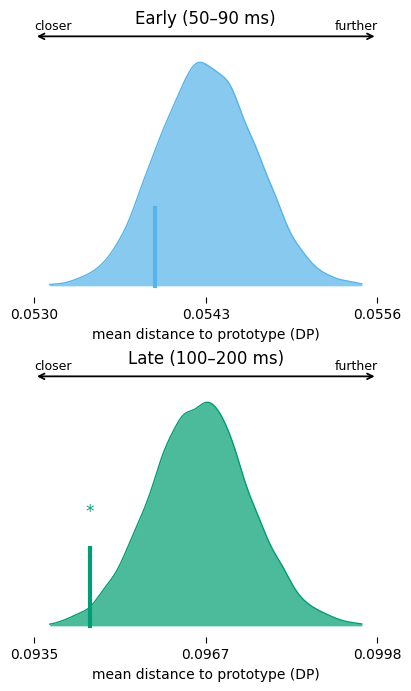

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Early & Late Distance to Prototype (DP): two rotated-density subplots
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import jit
from statsmodels.stats.multitest import multipletests

# ------------------------------ Paths & Config ------------------------------
META_PATH = 'downloads/hvm_public_extended_meta.csv'
EVEN_PATH = 'downloads/Spike_count_even_sessions.npy'
ODD_PATH  = 'downloads/Spike_count_odd_sessions.npy'

FIG_DIR   = 'Figures'
N_PERM    = 10_000
RNG_SEED  = 42

# Color codes: early = blue, late = green
PALETTE_EARLY = {'Perm': '#56B4E9', 'Obs': '#56B4E9'}
PALETTE_LATE  = {'Perm': '#009E73', 'Obs': '#009E73'}

plt.rcParams.update({"svg.fonttype": "none"})  # keep text editable in SVG
os.makedirs(FIG_DIR, exist_ok=True)

# ------------------------------ Helpers -------------------------------------
@jit
def sqeucl(mat: jnp.ndarray, vec: jnp.ndarray) -> jnp.ndarray:
    """Row-wise mean-squared Euclidean distance to vec."""
    return jnp.mean((mat - vec) ** 2, axis=1)

def q_to_stars(q: float) -> str:
    if q < 1e-4: return '****'
    if q < 1e-3: return '***'
    if q < 1e-2: return '**'
    if q < 5e-2: return '*'
    return ''

def _set_three_ticks(ax):
    """Force exactly three evenly spaced xticks on current x-limits."""
    xmin, xmax = ax.get_xlim()
    ticks = np.linspace(xmin, xmax, 3)
    ax.set_xticks(ticks)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

def plot_rotated_density_single(ax, title, obs, null_dist, q_val, xlabel, palette):
    """One rotated-density panel (with three xticks)."""
    # KDE grid on 0.1–99.9 % range (light truncation)
    p_lo, p_hi = np.percentile(null_dist, [0.1, 99.9])
    pad = 0.02 * (p_hi - p_lo)
    x_g = np.linspace(p_lo - pad, p_hi + pad, 200)
    dens = gaussian_kde(null_dist)(x_g)
    dens[dens < 0.005 * dens.max()] = 0
    max_d = dens.max() or 1e-8

    # density + observed line
    ax.fill_between(x_g, 0, dens, color=palette['Perm'], alpha=.7, lw=0)
    ax.plot(x_g, dens, color=palette['Perm'], lw=1)
    ln = 0.35 * max_d
    ax.plot([obs, obs], [0, ln], color=palette['Obs'], lw=3)

    # significance stars (use q-value)
    stars = q_to_stars(q_val)
    if stars:
        ax.text(obs, ln + 0.12 * max_d, stars, ha='center', va='bottom',
                fontsize=12, color=palette['Obs'])

    # cosmetics
    ax.set_yticks([])
    ax.tick_params(axis='y', left=False, labelleft=False)
    for s in ax.spines.values():
        s.set_visible(False)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.tick_params(axis='x', bottom=True, labelbottom=True, length=4)
    ax.set_title(title, fontsize=12, pad=20)
    _set_three_ticks(ax)

    # horizontal “closer↔further” guide
    arrow_y = 1.06
    ax.annotate('', xy=(1, arrow_y), xytext=(0, arrow_y),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='<->', lw=1.3, color='black'),
                clip_on=False)
    ax.text(0, arrow_y + 0.015, 'closer', transform=ax.transAxes,
            ha='left', va='bottom', fontsize=9)
    ax.text(1, arrow_y + 0.015, 'further', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=9)

def compute_dp_for_window(X_full: jnp.ndarray,
                          meta: pd.DataFrame,
                          rng: np.random.Generator):
    """
    Compute grand-mean Distance to Prototype (DP) and its null for a window.

    Processing:
      1) center features
      2) PCA to 50 dims (on all trials in the window)
      3) build object prototypes from LOW-variation exemplars in PCA space
      4) compute per-object mean DP for HIGH-variation images
      5) null by resampling category-matched HIGH-variation images (exclude same object)
    """
    # masks (accept both numeric and string encodings if present)
    var_col = meta['variation'].values
    low_var_mask  = (var_col == 0) | (var_col == 'background_only')
    high_var_mask = (var_col == 3) | (var_col == 'full_variation') | (var_col == 'full')

    # 1) center (as jnp)
    X_full = jnp.array(X_full)
    mean_vec = jnp.mean(X_full, axis=0)
    Xc = X_full - mean_vec

    # 2) PCA(50) with SVD
    _, _, Vt = jnp.linalg.svd(Xc, full_matrices=False)
    comps = Vt[:50]  # (50, D)
    Z = (X_full - mean_vec) @ comps.T  # (n_trials, 50)

    # numpy views for metadata
    obj_all = meta['object_name'].values
    cat_all = meta['category_name'].values

    dist_true  = []
    dist_nulls = []

    for obj in pd.unique(obj_all):
        lv_idx = np.where(low_var_mask & (obj_all == obj))[0]
        hv_idx = np.where(high_var_mask & (obj_all == obj))[0]
        if lv_idx.size == 0 or hv_idx.size == 0:
            continue

        # prototype in PCA space
        template = jnp.mean(Z[lv_idx], axis=0)

        # observed DPs for this object's HIGH-variation images
        dists = np.asarray(sqeucl(Z[hv_idx], template))
        dist_true.append(dists.mean())

        # category-matched HIGH-variation pool excluding this object
        cat = cat_all[lv_idx[0]]
        pool_mask = high_var_mask & (cat_all == cat) & (obj_all != obj)
        pool_idx = np.where(pool_mask)[0]
        if pool_idx.size == 0:
            continue
        pool_d = np.asarray(sqeucl(Z[pool_idx], template))

        # null: resample same count as hv_idx, take mean; repeat N_PERM
        perm_means = rng.choice(pool_d, size=(N_PERM, hv_idx.size), replace=True).mean(axis=1)
        dist_nulls.append(perm_means)

    dist_true  = np.array(dist_true)
    if len(dist_nulls) == 0:
        emp_dist  = np.nan
        null_dist = np.full(N_PERM, np.nan, dtype=float)
        p_dist    = np.nan
    else:
        dist_nulls = np.vstack(dist_nulls)         # (n_obj, N_PERM)
        emp_dist   = dist_true.mean() if dist_true.size else np.nan
        null_dist  = dist_nulls.mean(axis=0)       # (N_PERM,)
        p_dist     = (null_dist <= emp_dist).mean() if np.isfinite(emp_dist) else np.nan

    return float(emp_dist), np.asarray(null_dist, float), float(p_dist)

# ------------------------------ Data & Windows ------------------------------
print('Loading metadata …')
meta = pd.read_csv(META_PATH)

print('Loading neural data …')
rate = (np.load(EVEN_PATH) + np.load(ODD_PATH)) / 2.0  # trials × channels × timebins

# 10-ms bins edges (left edges): 0,10,...,190
time_edges = np.arange(0, 200, 10)

# Early window: 50–90 ms
early_bins = np.where((time_edges >= 50) & (time_edges <= 90))[0]

# Late window: 100–200 ms
late_bins  = np.where((time_edges >= 100) & (time_edges <= 200))[0]

# Flatten per window (channels × selected timebins)
X_early = rate[:, :, early_bins].reshape(rate.shape[0], -1).astype('float32')
X_late  = rate[:, :, late_bins ].reshape(rate.shape[0], -1).astype('float32')

# ------------------------------ DP for both windows -------------------------
rng = np.random.default_rng(RNG_SEED)

print('Computing DP (early 50–90 ms) …')
emp_e, null_e, p_e = compute_dp_for_window(X_early, meta, rng)
print(f"Early DP grand mean = {emp_e:.4f}, p = {p_e:.4g}")

print('Computing DP (late 100–200 ms) …')
emp_l, null_l, p_l = compute_dp_for_window(X_late,  meta, rng)
print(f"Late  DP grand mean = {emp_l:.4f}, p = {p_l:.4g}")

# ------------------------------ BH–FDR & Plot -------------------------------
# FDR across the two windows; use q-values to place stars
p_vec = np.array([p_e, p_l], dtype=float)
mask  = ~np.isnan(p_vec)
q_vec = np.full_like(p_vec, np.nan, dtype=float)
if mask.any():
    _, q_corr, _, _ = multipletests(p_vec[mask], method='fdr_bh')
    q_vec[mask] = q_corr
q_e, q_l = q_vec.tolist()

fig, axes = plt.subplots(2, 1, figsize=(4.0, 6.8), constrained_layout=True)
plot_rotated_density_single(
    axes[0], 'Early (50–90 ms)',
    emp_e, null_e, q_e,
    'mean distance to prototype (DP)', PALETTE_EARLY
)
plot_rotated_density_single(
    axes[1], 'Late (100–200 ms)',
    emp_l, null_l, q_l,
    'mean distance to prototype (DP)', PALETTE_LATE
)

for ext in ('png', 'svg', 'pdf'):
    fig.savefig(os.path.join(FIG_DIR, f'distance_to_prototype_early_late.{ext}'), dpi=300)
print(f"Figure saved to {FIG_DIR}/distance_to_prototype_early_late.(png|svg|pdf)")

# Contribution of category and position priors to object recognition

## Analysis

Loading metadata …
Loading neural data …
Running PCA (50 comps) …
Figure saved to Figures/gain_rotated_density_dp.(png|svg|pdf)
Saved q-values to Statistics/q_values_gain_dp.npz


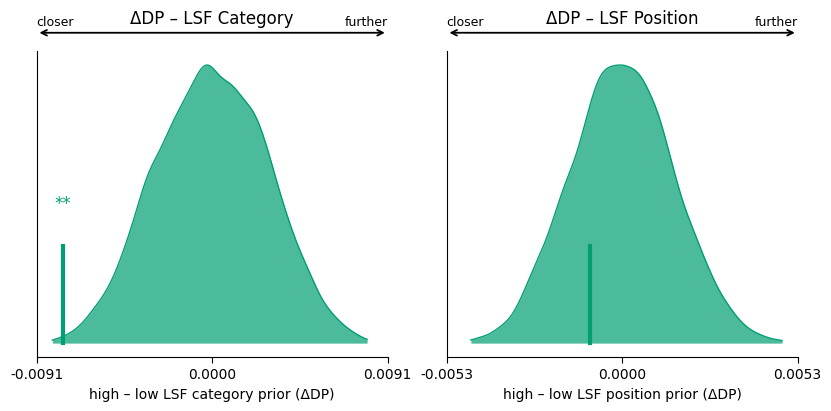

In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Δ Distance to Prototype (DP): LSF-category & LSF-position gains (late window)
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import jit

META_PATH      = 'downloads/hvm_public_extended_meta.csv'
EVEN_PATH      = 'downloads/Spike_count_even_sessions.npy'
ODD_PATH       = 'downloads/Spike_count_odd_sessions.npy'
CAT_PROB_PATH  = 'downloads/mean_predprob_per_trial_lowpass.npy'
POS_ERR_PATH   = 'downloads/mean_pos_error_per_trial.npy'

FIG_DIR        = 'Figures'
STAT_DIR       = 'Statistics'
N_PERM         = 10_000   # permutations / sign-flips
RNG_SEED       = 42

PALETTE = {'Perm': '#009E73', 'Obs': '#009E73'}
plt.rcParams.update({"svg.fonttype": "none"})  # editable text in SVG

# Create Statistics directory if it doesn't exist
os.makedirs(STAT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# Needed here (in case not imported above in the notebook)
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# ───────────────────────────── helper functions ──────────────────────────────
@jit
def sqeucl(mat: jnp.ndarray, vec: jnp.ndarray) -> jnp.ndarray:
    """Row-wise mean-squared Euclidean distance to *vec*."""
    return jnp.mean((mat - vec) ** 2, axis=1)

def q_to_stars(q: float) -> str:
    if q < 1e-4: return '****'
    if q < 1e-3: return '***'
    if q < 1e-2: return '**'
    if q < 5e-2: return '*'
    return ''

def _set_three_ticks(ax):
    """Set symmetric x-limits and ticks at [-L, 0, +L] with 0 centered."""
    xmin, xmax = ax.get_xlim()
    L = float(max(abs(xmin), abs(xmax)))
    if not np.isfinite(L) or L == 0:
        L = 1.0
    ax.set_xlim(-L, L)
    ax.set_xticks([-L, 0.0, L])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

def plot_rotated_density_single(ax, title, obs, null_dist, q_val, xlabel):
    """One rotated-density panel (with three xticks)."""
    # KDE grid on 0.1–99.9 % range
    p_lo, p_hi = np.percentile(null_dist, [0.1, 99.9])
    pad = 0.02 * (p_hi - p_lo)
    x_g = np.linspace(p_lo - pad, p_hi + pad, 200)
    dens = gaussian_kde(null_dist)(x_g)
    dens[dens < 0.005 * dens.max()] = 0
    max_d = dens.max() or 1e-8

    # density + observed line
    ax.fill_between(x_g, 0, dens, color=PALETTE['Perm'], alpha=.7, lw=0)
    ax.plot(x_g, dens, color=PALETTE['Perm'], lw=1)
    ln = 0.35 * max_d
    ax.plot([obs, obs], [0, ln], color=PALETTE['Obs'], lw=3)

    # stars (use q-value)
    if (stars := q_to_stars(q_val)):
        ax.text(obs, ln + 0.12 * max_d, stars, ha='center', va='bottom',
                fontsize=12, color=PALETTE['Obs'])

    # cosmetics
    ax.set_yticks([])
    ax.tick_params(axis='y', left=False, labelleft=False)
    for s in ax.spines.values():
        s.set_visible(False)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.tick_params(axis='x', bottom=True, labelbottom=True, length=4)
    ax.set_title(title, fontsize=12, pad=20)

    # enforce three ticks after limits settle
    _set_three_ticks(ax)

    # arrow
    arrow_y = 1.06
    ax.annotate('', xy=(1, arrow_y), xytext=(0, arrow_y),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='<->', lw=1.3, color='black'),
                clip_on=False)
    ax.text(0, arrow_y + 0.015, 'closer', transform=ax.transAxes,
            ha='left', va='bottom', fontsize=9)
    ax.text(1, arrow_y + 0.015, 'further', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=9)

# --- metadata
print('Loading metadata …')
meta = pd.read_csv(META_PATH)
low_var  = (meta.variation == 0) | (meta.variation == 'background_only')
high_var = (meta.variation == 3) | (meta.variation == 'full_variation') | (meta.variation == 'full')
high_idx = np.nonzero(high_var.values)[0]
g2h = -np.ones(len(meta), int); g2h[high_idx] = np.arange(high_idx.size)

# --- neural data (100–200 ms)
print('Loading neural data …')
rate = (np.load(EVEN_PATH) + np.load(ODD_PATH)) / 2.0
t_bins = np.arange(0, 200, 10)
late_mask = (t_bins >= 100) & (t_bins <= 200)
X = rate[:, :, late_mask].reshape(rate.shape[0], -1).astype('float32')
X = jnp.array(X)

# --- PCA (50 components)
print('Running PCA (50 comps) …')
X_mean = X.mean(axis=0)
Xc = X - X_mean
_, _, Vt = jnp.linalg.svd(Xc, full_matrices=False)
comps = Vt[:50]  # 50 principal axes

# project data
proj_all  = (X - X_mean) @ comps.T
proj_high = proj_all[high_idx]

hv_obj = meta.object_name.values[high_idx]
hv_cat = meta.category_name.values[high_idx]

cat_prob = np.load(CAT_PROB_PATH)
pos_err  = np.load(POS_ERR_PATH)

rng = np.random.default_rng(RNG_SEED)

# Collect per-object ΔDP components
gain_cat, gain_pos = [], []

for obj in meta.object_name.unique():
    lv_idx = meta[(meta.object_name == obj) & low_var].index.values
    hv_idx = meta[(meta.object_name == obj) & high_var].index.values
    if lv_idx.size == 0 or hv_idx.size == 0:
        continue

    # prototype from LOW-variation in PCA space
    template = proj_all[lv_idx].mean(axis=0)

    # distances for this object’s HIGH-variation images (in PCA space)
    hv_hi = g2h[hv_idx]
    dists = np.asarray(sqeucl(proj_high[hv_hi], template))  # per-image DP

    # LSF gains (category prior and position prior)
    cp = cat_prob[hv_hi]
    pe = pos_err[hv_hi]

    mask_exp = cp > np.median(cp);  mask_un  = ~mask_exp
    mask_loc = pe < np.median(pe);  mask_mis = ~mask_loc

    if mask_exp.any() and mask_un.any():
        gain_cat.append(dists[mask_exp].mean() - dists[mask_un].mean())
    if mask_loc.any() and mask_mis.any():
        gain_pos.append(dists[mask_loc].mean() - dists[mask_mis].mean())

# --- stats (sign-flip nulls for the two ΔDP panels)
emp_cat = float(np.mean(gain_cat)) if len(gain_cat) else np.nan
emp_pos = float(np.mean(gain_pos)) if len(gain_pos) else np.nan

signs_cat = rng.choice([-1, 1], size=(N_PERM, len(gain_cat))) if len(gain_cat) else np.empty((0,0))
signs_pos = rng.choice([-1, 1], size=(N_PERM, len(gain_pos))) if len(gain_pos) else np.empty((0,0))

null_cat = (np.array(gain_cat)[None, :] * signs_cat).mean(axis=1) if len(gain_cat) else np.array([np.nan])
null_pos = (np.array(gain_pos)[None, :] * signs_pos).mean(axis=1) if len(gain_pos) else np.array([np.nan])

# one-sided p-values
p_cat = float((null_cat <= emp_cat).mean()) if len(gain_cat) else np.nan
p_pos = float((null_pos <= emp_pos).mean()) if len(gain_pos) else np.nan

# --- BH–FDR (use q-values on the figures)
p_vec = np.array([p_cat, p_pos], dtype=float)
mask  = ~np.isnan(p_vec)
q_vec = np.full_like(p_vec, np.nan, dtype=float)
if mask.any():
    _, q_corr, _, _ = multipletests(p_vec[mask], method='fdr_bh')
    q_vec[mask] = q_corr
q_cat, q_pos = q_vec.tolist()

# Save both raw p and FDR-corrected q values
np.save(os.path.join(STAT_DIR, 'p_value_gain_cat.npy'), p_cat)
np.save(os.path.join(STAT_DIR, 'p_value_gain_pos.npy'), p_pos)
np.savez(os.path.join(STAT_DIR, 'q_values_gain_dp.npz'), q_cat=q_cat, q_pos=q_pos)

# --- plotting (ONLY the two ΔDP panels; pass q-values to star-logic)
fig, axes = plt.subplots(1, 2, figsize=(8.2, 4), constrained_layout=True)

plot_rotated_density_single(
    axes[0], 'ΔDP – LSF Category',
    emp_cat, null_cat, q_cat,
    'high – low LSF category prior (ΔDP)'
)
plot_rotated_density_single(
    axes[1], 'ΔDP – LSF Position',
    emp_pos, null_pos, q_pos,
    'high – low LSF position prior (ΔDP)'
)

sns.despine()
for ext in ('png', 'svg', 'pdf'):
    fig.savefig(os.path.join(FIG_DIR, f'gain_rotated_density_dp.{ext}'), dpi=300)
print(f'Figure saved to {FIG_DIR}/gain_rotated_density_dp.(png|svg|pdf)')
print(f"Saved q-values to {STAT_DIR}/q_values_gain_dp.npz")

# Download figures and statistics

In [5]:
import os
from google.colab import files

# Define the directories to zip
directories_to_zip = ["Figures", "Statistics"]
zip_filename = "results_LSF_top_down.zip"

# Check if directories exist before zipping
existing_directories = [d for d in directories_to_zip if os.path.exists(d)]

if existing_directories:
    # Create a zip archive of the specified directories
    zip_command = f"zip -r {zip_filename} {' '.join(existing_directories)}"
    os.system(zip_command)

    # Provide a download link for the zip file
    if os.path.exists(zip_filename):
        print(f"Created {zip_filename}. You can download it using the link below.")
        files.download(zip_filename)
    else:
        print(f"Failed to create {zip_filename}.")
else:
    print("Neither the 'Figures' nor the 'Statistics' directory was found.")

Created results_LSF_top_down.zip. You can download it using the link below.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>